In [6]:
from pydub import AudioSegment
import scipy
import random

def label_out(inp):
    temp=''
    for c in inp:
        if(c=='/'):
            break
        else:
            temp=temp+c
#     temp = word_dict[temp]
    return temp

/usr/local/lib/python3.6/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [7]:

import numpy as np

#%%
# From Baidu ba-dls-deepspeech - https://github.com/baidu-research/ba-dls-deepspeech
# Character map list

char_map_str = """
<SPACE> 0
a 1
b 2
c 3
d 4
e 5
f 6
g 7
h 8
i 9
j 10
k 11
l 12
m 13
n 14
o 15
p 16
q 17
r 18
s 19
t 20
u 21
v 22
w 23
x 24
y 25
z 26
' 27
"""

char_map = {}
index_map = {}

for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch
char_map[' ']=0
index_map[0] = ' '


In [90]:
def get_param(Y):
    
    labels = np.zeros((12,))
    new = []
    for label in enumerate(Y):
        
        for c in label:
#             print(c)
            if c not in char_map:
                continue
            elif c == "'":
                continue
            else:
#                 print(char_map[c])
                ch = char_map[c]
                new.append(ch)
        
#       if(len(new) < max_label):
#         new.append(0)
#     print(new)
    while(len(new) < 12):
        new.append(27)
    labels = np.array(new)
    max_label = 12
#     input_length = np.array([max_label for _ in Y])
#     label_length = np.array([max_label for _ in Y])

#     return labels
    return labels , input_length , label_length

In [9]:
char_map

{' ': 0,
 "'": 27,
 '<SPACE>': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [91]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        input_length = np.array([101 for _ in range(self.batch_size)])
        label_length = np.array([12 for _ in range(self.batch_size)])

        return X, y, input_length, label_length

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = []
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            a = graph_spectrogram('aud_data/' +  ID )
            b = np.zeros((101,198))
            if (np.shape(a)!=(101,198)):
                b[:,:a.shape[1]] +=a
                c = b
            else:
                c = a
                
            d, ll = self.__string_from_words(list_IDs_temp,ID)
            e = graph_spectrogram(d)
            f = np.zeros((101,398))
            if (np.shape(e)!=(101,398)):
                f[:,:e.shape[1]] +=e
                X[i,] = f
            else:
                X[i,] = e
            
#             Store class
#             temp = label_out(ID)
#             print(temp)
#             print(ll)
            lf = get_param(ll)
            y.append(lf)
#             y[i] = labels[i]  
        return X, y

    def __string_from_words(self, list_IDs_temp, ID):
        
        sound1 = AudioSegment.from_wav('aud_data/' +  ID )
        id1 = label_out(ID)
        temp_audio = random.choice(list_IDs_temp)
        if(temp_audio != ID):
            id2 = label_out(temp_audio)
#             sound2 = AudioSegment.from_wav('aud_data/' + temp_audio)
        else:
            id2=id1
        combined_sounds = sound1+ AudioSegment.from_wav('aud_data/' + temp_audio)
        label_str = id1 + " " + id2
#         print(label_str)
        combined_sounds.export('dump.wav', format="wav")
        return "dump.wav", label_str
        os.remove('dump.wav')
            
        

In [11]:
from keras.models import Sequential

import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import soundfile as sf
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [12]:
path = '/home/isro/conversational_bot'
print(path)
os.chdir(path)
os.getcwd()
os.listdir()

/home/isro/conversational_bot


['.git',
 'coursera',
 'dump.wav',
 'Untitled.ipynb',
 'data_aug_func.ipynb',
 'aud_data',
 'validation_list.txt',
 'testing_list.txt',
 'meta (2).tsv',
 'aimlbot',
 'vecs (2).tsv',
 'speech_recog_ctc.ipynb',
 'word_embeddings.ipynb',
 'Word_embeddings',
 '_background_noise_',
 'data_gen_aud_aug.ipynb',
 'mod_aud.flac',
 '.ipynb_checkpoints',
 'LICENSE',
 'README.md']

In [13]:
file = open("testing_list.txt")
# print(file.read())

In [92]:
train_list = []
valid_list = []
def listing(file, l):
    crimefile = open(file, 'r')
    for line in crimefile.readlines():
    #     row.append([line])
        for i in line.split("\n"):
            l.append(i)
    for e in l:
        if (e == ''):
            l.remove(e)

listing("testing_list.txt",train_list)
listing("validation_list.txt", valid_list)

In [93]:
print(train_list[4])

bed/1528225c_nohash_0.wav


In [94]:
labels= []
labels_valid=[]

word_dict = {"bed": 0, "bird":1, "cat":2, "dog":3, "down":4, "eight":5, "five":6,
             "four":7, "go":8,"happy":9,"house":10,"left":11,
             "marvin":12,"nine":13,"no":14,"off":15,"one":16,"on":17,"two":18,
             "right":19,"seven":20,"sheila":21,"stop":22,"three":23,"tree":24,
             "up":25,"wow":26,"yes":27,"zero":28, "six": 29}

def make_labels(ls,file):
    for i in file:
        temp=''
        for c in i:
            if(c=='/'):
                break
            else:
                temp=temp+c
#         ls.append(temp)
        ls.append(word_dict[temp])
#     print(temp)
# print(labels[4])
make_labels(labels, train_list)
make_labels(labels_valid, valid_list)

print(labels)
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [95]:
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    noise_inj(wav_file, 0.1)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate , data = wavfile.read(wav_file)
    return rate, data

def noise_inj(audio, noise_factor):      #introducing random noise in the audio file
    sr,data = get_wav_info(audio)
    noise = np.random.randn(len(data)) 
    aug_data=data + noise_factor * noise 
    aug_data = aug_data.astype(type(data[0])) 
#     sf.write("mod_aud.flac", aug_data, sr)
    return aug_data
 

In [96]:
from keras.models import Sequential
# import DataGenerator

# Parameters
params = {'dim': (101,398),
          'batch_size': 32,
          'n_classes': 6,
          'n_channels': 1,
          'shuffle': True}


# Generators
training_generator = DataGenerator(train_list, labels, **params)
validation_generator = DataGenerator(valid_list, labels, **params)

(array([[[1.49131696e-02, 1.00547068e-02, 3.92610115e-04, ...,
          3.80383989e-01, 3.35057308e-01, 1.69895642e+00],
         [8.78859839e-02, 8.41903392e-02, 1.03664767e-02, ...,
          5.30520697e+00, 8.66943894e-01, 3.76402438e-01],
         [5.19148340e-01, 8.49025471e-01, 4.45150087e-01, ...,
          1.26702943e+01, 3.22660495e+00, 3.79380275e+00],
         ...,
         [4.06804080e-05, 3.88691725e-05, 4.10278790e-05, ...,
          2.25658454e-03, 2.93553593e-04, 2.53366751e-03],
         [2.51512779e-05, 2.28404500e-05, 2.04331225e-05, ...,
          1.35050631e-03, 3.76525927e-03, 1.80684702e-02],
         [1.05807723e-05, 1.07992423e-06, 9.52673551e-07, ...,
          2.27008835e-03, 1.07219800e-04, 8.37343154e-03]],
 
        [[9.08396162e+03, 7.97867592e+03, 5.35777811e+03, ...,
          1.73904807e-02, 5.40562865e-03, 8.74584379e-02],
         [5.03989293e+03, 4.06572524e+03, 2.97613503e+03, ...,
          2.51850588e-01, 6.17061511e-01, 8.49350930e-01],
       

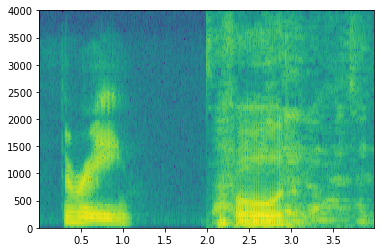

In [97]:
# x, y = training_generator.__getitem__(0)
# print(y[0])
# print(x[0])
training_generator.__getitem__(0)

In [98]:
x=np.array(x)
y=np.array(y)
x=x.reshape(32,101,398)
print(x.shape)
print(np.shape(y))

(32, 101, 398)
(32, 3)


In [99]:

from keras.layers import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.utils import plot_model

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length )    
    
        
#%%
class CTC():
    """
    Usage:
        sr_ctc = CTC(enter input_size and output_size)
        sr_ctc.build()
        sr_ctc.m.compile()
        sr_ctc.tm.compile()
    """       
    def __init__(self,
                 input_size=None, 
                 output_size=None,
#                  batch_size=None,
                 initializer='glorot_uniform'):
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None
        self.tm = None
                   
    def build(self, 
              conv_filters = 200,
              conv2d_filters = 13,
              conv_size = 5,
              conv2d_strides = 1,
              conv_strides = 4,
              act = 'relu',
              rnn_layers = 2,
              LSTM_units = 128,
              drop_out = 0.5):
#         input_shape= (101,398,1)
        input_data = Input(shape = self.input_size, name = 'the_inputs')
#         x = Conv2D(conv2d_filters,
#                    conv_size,
#                    strides = (conv2d_strides, conv2d_strides),
#                    padding = "same",
#                    input_shape=input_shape,
#                    name = "conv2d1")(i)
#         x = BatchNormalization()(x)
#         x = Activation(act)(x)
#         x = Conv2D(conv2d_filters,
#                    conv_size,
#                    strides = (conv2d_strides , conv2d_strides),
#                    padding = "same",
#                    name = "conv2d2")(x)
#         x = BatchNormalization()(x)
#         x = Activation(act)(x)
#         x = Reshape([202,-1])(x)
        x = Conv1D(conv_filters, 
                   conv_size, 
                   strides = conv_strides,
                   padding = "same", 
                   name = 'conv1d1')(input_data)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Conv1D(conv_filters, 
                   conv_size, 
                   strides = conv_strides,
                   padding = "same", 
                   name = 'conv1d2')(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
# #         print(x.shape)
#         x = Reshape([200,13])(x)
#         x = Dense(29 , activation="softmax", name ="dense")(x)
#         x = Reshape([29,-1])(x)
        for _ in range(rnn_layers):          
            x = Bidirectional(LSTM(LSTM_units, 
                                   return_sequences = True))(x)
            x = Dropout(drop_out)(x)
            x = BatchNormalization()(x)
        y_pred = TimeDistributed(Dense(self.output_size, 
                                       activation = 'softmax'))(x)        
        # ctc inputs
        labels = Input(name='the_labels', shape=[None,], dtype='int32')
        input_length = Input(name='input_length', shape=[1], dtype='int32')
        label_length = Input(name='label_length', shape=[1], dtype='int32')    
        # Keras doesn't currently support loss funcs with extra parameters
        # so CTC loss is implemented in a lambda layer
        loss_out = Lambda(ctc_lambda_func, 
                          output_shape=(1,), 
                          name='ctc')([y_pred,
                                        labels,
                                        input_length,
                                        label_length])        
        self.tm = Model(inputs = input_data,
                        outputs = y_pred)
        self.m = Model(inputs = [input_data, 
                                 labels, 
                                 input_length, 
                                 label_length], 
                        outputs = loss_out)
        return self.m, self.tm

In [100]:
def ctc(y_true, y_pred):
    return y_pred

In [101]:
sr_ctc = CTC((101,398), 12)
sr_ctc.build()

(<keras.engine.training.Model at 0x7f74d8b1eb38>,
 <keras.engine.training.Model at 0x7f74d8b1e588>)

In [102]:
sr_ctc.m.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, 101, 398)     0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, 26, 200)      398200      the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 26, 200)      800         conv1d1[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 26, 200)      0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [103]:
sr_ctc.m.compile(loss = ctc, optimizer = 'adam', metrics = ['accuracy'])
sr_ctc.tm.compile(loss = ctc, optimizer = 'adam')

In [104]:
labels_train, input_length, label_length = get_param(Y = labels)
labels_val, input_length_val, label_length_val = get_param(Y = labels)

In [105]:
print(labels_train)


[27 27 27 27 27 27 27 27 27 27 27 27]


Epoch 1/2


ValueError: Output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: (array([[[2.58959041e+03, 2.13976476e+03, 1.94327208e+03, ...,
         1.98954459e-01, 1.17607399e-01, 1.07846733e+00],
        [1.40989927e+03, 1.06040324e+03, 8.81887287e+02, ...,
         1.92856251e-01, 5.03379971e-01, 5.85803449e+00],
        [3.91290116e+00, 3.65832109e-01, 4.39840791e+00, ...,
         3.21265814e+01, 4.04260818e+01, 2.77137252e+01],
        ...,
        [1.47714266e-05, 7.36951686e-06, 1.88119953e-05, ...,
         4.49032183e-04, 1.12535964e-03, 1.23993672e-03],
        [1.97164480e-05, 4.29515734e-06, 1.17859580e-05, ...,
         3.67311449e-04, 2.10890769e-03, 2.27296689e-03],
        [3.35441641e-06, 7.38723894e-07, 1.33157651e-07, ...,
         7.39989410e-06, 1.24761736e-04, 5.79217147e-06]],

       [[5.24351571e-07, 1.28284214e-03, 9.75146563e-04, ...,
         4.97354994e+00, 7.21343836e+00, 1.09485750e+00],
        [9.22152262e-03, 4.38129794e-03, 4.89843030e-03, ...,
         1.09768485e+01, 1.21906547e+01, 3.34181819e+01],
        [2.46895379e-02, 1.38262793e-02, 1.29690660e-02, ...,
         5.98029962e+00, 4.01282358e+00, 1.11245183e+01],
        ...,
        [1.63119577e-05, 3.01688255e-05, 1.39207090e-05, ...,
         1.32142114e-05, 3.02047855e-05, 2.48761577e-05],
        [4.36035238e-05, 5.16582197e-06, 8.34794857e-06, ...,
         5.95491296e-06, 8.54795867e-06, 4.89330351e-05],
        [2.76044644e-05, 1.32181428e-07, 1.32209763e-05, ...,
         4.46226144e-06, 5.81075920e-07, 1.31731814e-05]],

       [[2.71581988e+02, 3.47735285e+02, 1.81251732e+02, ...,
         1.46357924e+03, 2.03348759e+03, 2.23805057e+03],
        [2.06493955e+02, 1.91811981e+02, 1.17523948e+02, ...,
         6.93561573e+02, 1.05867038e+03, 1.39600921e+03],
        [1.22365827e+01, 4.04536890e+00, 1.70792146e+00, ...,
         5.62665096e+02, 2.36506394e+02, 7.13218580e+01],
        ...,
        [8.06892451e-05, 4.48565560e-05, 1.13495045e-05, ...,
         3.81139156e-05, 1.32282814e-04, 3.94026888e-05],
        [7.59354433e-05, 1.82707250e-05, 3.90141315e-05, ...,
         1.70875176e-05, 7.74825691e-05, 5.27321116e-05],
        [6.24308646e-06, 1.20002726e-06, 2.51542707e-05, ...,
         1.43515919e-05, 2.04293094e-05, 1.96396259e-05]],

       ...,

       [[5.52466025e-03, 3.03165596e-07, 9.64213656e-03, ...,
         4.97354994e+00, 7.21343836e+00, 1.09485750e+00],
        [1.90195293e-02, 2.75563143e-01, 1.10710227e-01, ...,
         1.09768485e+01, 1.21906547e+01, 3.34181819e+01],
        [2.81558308e-01, 2.81235194e+00, 8.44135867e-01, ...,
         5.98029962e+00, 4.01282358e+00, 1.11245183e+01],
        ...,
        [3.42030235e-05, 5.23441961e-06, 8.00365955e-06, ...,
         1.32142114e-05, 3.02047855e-05, 2.48761577e-05],
        [4.81873055e-05, 6.77948647e-06, 3.38331782e-06, ...,
         5.95491296e-06, 8.54795867e-06, 4.89330351e-05],
        [4.77326413e-05, 5.07172892e-06, 1.94333269e-06, ...,
         4.46226144e-06, 5.81075920e-07, 1.31731814e-05]],

       [[9.05953033e+00, 2.25083933e+01, 9.55468934e+00, ...,
         1.39107230e-02, 6.82624381e-03, 2.59074922e-02],
        [3.05424936e+02, 6.37152261e+02, 5.20727343e+02, ...,
         1.28374410e-02, 5.85107481e-03, 6.69353094e-02],
        [1.06163539e+02, 7.49063434e+02, 1.79107706e+02, ...,
         2.09377360e-02, 2.91810430e-02, 1.29921290e-01],
        ...,
        [4.07281867e-02, 1.16360541e-01, 1.79171838e-01, ...,
         5.11243899e-05, 4.44374735e-05, 1.38186096e-05],
        [1.87320742e-02, 5.76624634e-02, 4.59994982e-02, ...,
         6.63110186e-05, 1.67850505e-05, 1.47800784e-05],
        [2.39640240e-03, 2.07842758e-03, 1.21709705e-05, ...,
         1.68436392e-05, 2.27203782e-08, 4.60705066e-06]],

       [[2.36639624e+00, 3.71358126e+01, 5.37850970e+02, ...,
         1.39107230e-02, 6.82624381e-03, 2.59074922e-02],
        [3.26459610e+02, 2.70022047e+02, 4.79649229e+02, ...,
         1.28374410e-02, 5.85107481e-03, 6.69353094e-02],
        [6.46350830e+01, 7.36848374e+01, 2.08576807e+01, ...,
         2.09377360e-02, 2.91810430e-02, 1.29921290e-01],
        ...,
        [4.24290984e-05, 5.90208493e-06, 3.08686523e-05, ...,
         5.11243899e-05, 4.44374735e-05, 1.38186096e-05],
        [2.71732781e-05, 3.52819430e-06, 9.22953994e-06, ...,
         6.63110186e-05, 1.67850505e-05, 1.47800784e-05],
        [5.53831784e-07, 2.12628920e-06, 5.76905965e-06, ...,
         1.68436392e-05, 2.27203782e-08, 4.60705066e-06]]]), [(array([ 2,  5,  4,  0, 15, 14, 27, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 3,  1, 20,  0, 19,  9, 24, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 6, 15, 21, 18,  0,  2,  5,  4, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([20, 18,  5,  5,  0, 21, 16, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([26,  5, 18, 15,  0,  6, 15, 21, 18, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([20, 18,  5,  5,  0, 19,  9, 24, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 5,  9,  7,  8, 20,  0,  5,  9,  7,  8, 20, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 5,  9,  7,  8, 20,  0,  6,  9, 22,  5, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([15, 14,  0,  6,  9, 22,  5, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 4, 15, 23, 14,  0, 20, 18,  5,  5, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 6,  9, 22,  5,  0, 15, 14, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 7, 15,  0, 21, 16, 27, 27, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([20, 18,  5,  5,  0, 19,  8,  5,  9, 12,  1, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([15,  6,  6,  0,  2,  5,  4, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([20, 23, 15,  0,  6,  9, 22,  5, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([12,  5,  6, 20,  0, 26,  5, 18, 15, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 6,  9, 22,  5,  0, 15,  6,  6, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([19,  8,  5,  9, 12,  1,  0, 21, 16, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([19,  9, 24,  0,  4, 15, 23, 14, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 6, 15, 21, 18,  0,  6, 15, 21, 18, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 2,  5,  4,  0,  3,  1, 20, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([15,  6,  6,  0, 15,  6,  6, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 4, 15, 23, 14,  0, 15, 14, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([19, 20, 15, 16,  0, 19,  8,  5,  9, 12,  1, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([26,  5, 18, 15,  0,  8,  1, 16, 16, 25, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([15, 14,  0, 20, 23, 15, 27, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 6, 15, 21, 18,  0,  2,  5,  4, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([19,  9, 24,  0,  8,  1, 16, 16, 25, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([21, 16,  0, 20, 18,  5,  5, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([18,  9,  7,  8, 20,  0, 19,  9, 24, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([21, 16,  0, 20, 23, 15, 27, 27, 27, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12])), (array([ 8,  1, 16, 16, 25,  0, 20, 23, 15, 27, 27, 27]), array([12, 12, 12, ..., 12, 12, 12]), array([12, 12, 12, ..., 12, 12, 12]))], array([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
       101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
       101, 101, 101, 101, 101, 101]), array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]))

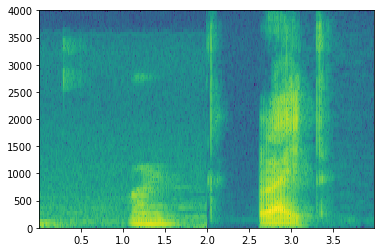

In [106]:
# sr_ctc.m.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=4)
#                        )

sr_ctc.m.fit_generator(training_generator, epochs=2)
